# Lab4 - Softmax & classification

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import math
import copy

# Implementacja sieci neurownowej przystowana do problemu klasyfikacji:

In [2]:
class MLP:

    def __init__(self, layers, weights, biases, activation_function='sigmoid', output_function='softmax'):
        self.layers = layers
        self.weights = weights
        self.biases = biases

        self.d_w = []
        self.d_b = []
        
        # only sigmoid available as activation function (for now)
        self.activation_function = self.sigmoid
        self.activation_derivative = self.sigmoid_derivative

        if output_function == 'softmax':
            self.output_function = self.softmax
        else:
            self.output_function = self.linear

    def forward_prop(self, inputs):
        """
        performs forward propagation
        """
        # activations and linear combinations passed to activation function
        self.a = []
        self.z = []

        activations = inputs
        self.a.append(activations)
        # propagate all but last layer with activaton function
        for i in range(len(self.layers) - 2):
            outputs = activations.dot(self.weights[i]) + self.biases[i]
            self.z.append(outputs)
            activations = self.activation_function(outputs)
            self.a.append(activations)

        # propagate last layer with output function
        results = activations.dot(self.weights[-1]) + self.biases[-1]
        self.z.append(results)
        activations = self.output_function(results)
        self.a.append(activations)
        return activations

    def backpropagation(self, y):
        """
        packpropagates error using activation functions derivatives
        """
        deltas = [None] * len(self.weights)

        # last delta
        if self.output_function == self.softmax:
            last_delta = []
            for val_a, val_y in zip(self.a[-1], y):
                err = val_y - val_a
                a = val_a.reshape(val_a.shape[0],)
                di_dj = - a * a.reshape(self.layers[-1], 1)
                d_d = np.diag(a) + di_dj
                last_delta.append(d_d.dot(err))
            last_delta = np.array(last_delta)
            deltas[-1] = copy.deepcopy(last_delta)
            
        elif self.output_function == self.linear:
            deltas[-1] = y - self.a[-1]

        # previous deltas
        for i in reversed(range(len(deltas) - 1)):
            deltas[i] = ((self.weights[i + 1].dot(deltas[i + 1].T)) * self.activation_derivative(self.z[i]).T).T

        # calculate derivatives
        d_b = [None] * len(deltas)
        d_w = [None] * len(deltas)
        for i, d in enumerate(deltas):
            d_w[i] = (d.T.dot(self.a[i])).T / y.shape[0]
            d_b[i] = (d.T.dot(np.ones((y.shape[0], 1)))).T / y.shape[0]

        return d_w, d_b

    def train(self, x, y, batch_size=20, epochs=500, lr=0.1):
        """
        trains neural network
        """
        # encode target for classification
        if self.output_function == self.softmax:
            encode = np.zeros((y.size, y.max() + 1))
            encode[np.arange(y.size), y.flatten()] = 1
            y = encode

        # randmize observations' order
        p = np.random.permutation(len(y))
        x = x[p]
        y = y[p]


        for epoch in range(epochs):
            i = 0
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                self.forward_prop(x_batch)
                
                # backpropagate
                d_w, d_b = self.backpropagation(y_batch)

                # gradient descent
                self.weights = [w + lr * dweight for w, dweight in zip(self.weights, d_w)]
                self.bias = [b + lr * dbias for b, dbias in zip(self.biases, d_b)]

            # print error
            if self.output_function == self.softmax:
                if epoch % 100 == 0 or epoch == epochs-1:
                    print("Epoch: {: <5} Cross entropy loss: {}".format(epoch, metrics.log_loss(np.argmax(y_batch, axis=1), self.a[-1])))
            else:
                if epoch % 100 == 0 or epoch == epochs-1:
                    print("Epoch: {: <5} Mean absolute error: {}".format(epoch,np.abs(y_batch - self.a[-1]).mean()))
                
    @staticmethod
    def softmax(x):
        e_x = np.exp(x.T - np.max(x, axis=1).T).T
        return (e_x.T / e_x.sum(axis=1).T).T

    @staticmethod
    def linear(x): 
        return(x)
    
    @staticmethod
    def sigmoid(x):
        return np.exp(x) / (1 + np.exp(x))

    @staticmethod
    def sigmoid_derivative(x):
        def sigmoid(x):
            return np.exp(x) / (1 + np.exp(x))
        return sigmoid(x) * (1 - sigmoid(x))

    def show_attributes(self):
        """
        gives basic information about the neural network
        """
        print("Neural Network attributes:")
        print("-------------------------")
        print("Number of neurons in layers: {}".format(self.layers))
        print("Activation function used: {}".format(self.activation_function))
        print("Output activation function used: {}".format(self.output_function))
        return



def generate_random_mlp(layers, activation_function ='sigmoid', output_function='softmax', start=-1, stop=1):
    """
    generates mlp with random weights given number of neurons in each layer and activation functions
    """
    weights = []
    biases = []

    for i in range(len(layers) - 1):
        weights.append(np.random.uniform(start, stop, layers[i] * layers[i + 1]).reshape(layers[i], layers[i + 1]))
        biases.append(np.random.uniform(start, stop, layers[i + 1]).reshape(1, layers[i+1]))
    mlp = MLP(layers, weights, biases, activation_function=activation_function, output_function=output_function)
    return mlp

Dla funkcji wyjściowej softmax będziemy używać miary cross entropy jako funkcji straty zamiast standardowego błędu średniokwadratowego. 

# Pierwszy zbiór: rings3-regular

In [3]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/classification/rings3-regular-training.csv')
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/classification/rings3-regular-test.csv')
train_df

,x,y,c
0,-93.563317,-76.345110,0
1,1.060114,-16.727040,0
2,24.396099,40.358822,0
3,-94.595137,-97.889250,0
4,-85.331382,-56.736933,0
...,...,...,...
1495,-3.227585,-69.846357,2
1496,-82.598085,-51.758017,2
1497,-46.601078,-21.654871,2
1498,-59.106450,-44.528442,2


Text(0.5, 1.0, 'Train split')

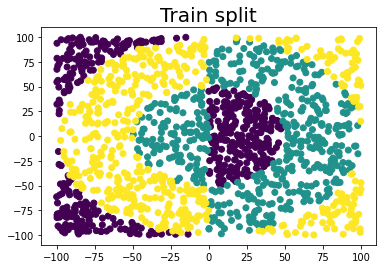

In [4]:
plt.scatter(train_df['x'], train_df['y'], c=train_df['c'])
plt.title('Train split', fontsize=20)

## skalowanie danych

In [5]:
x_train = np.asarray(train_df.iloc[:,0:2])
x_train_scaled = (x_train - np.mean(x_train, axis = 0))/np.std(x_train, axis = 0)

x_test = np.asarray(test_df.iloc[:,0:2])
x_test_scaled = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y_train = np.asarray(train_df.iloc[:,2]).reshape(-1, 1)

## pierwszy zbiór - funkcja softmax

In [6]:
mymlp = generate_random_mlp([2,64,64,64,64,3])
mymlp.train(x_train_scaled, y_train, epochs = 1000, batch_size=32, lr=0.01)
pred = mymlp.forward_prop(x_test_scaled)
result = np.argmax(pred, axis = 1)

Epoch: 0     Cross entropy loss: 2.866986255894992
Epoch: 100   Cross entropy loss: 1.0442102290336925
Epoch: 200   Cross entropy loss: 1.0070293965460053
Epoch: 300   Cross entropy loss: 0.9707787730545928
Epoch: 400   Cross entropy loss: 0.909625287643871
Epoch: 500   Cross entropy loss: 0.8149799420375965
Epoch: 600   Cross entropy loss: 0.7027623669600913
Epoch: 700   Cross entropy loss: 0.6004783387108908
Epoch: 800   Cross entropy loss: 0.5148748553527415
Epoch: 900   Cross entropy loss: 0.446037921733185
Epoch: 999   Cross entropy loss: 0.3932269192960129


Text(0.5, 1.0, 'rings3-regular-test, softmax')

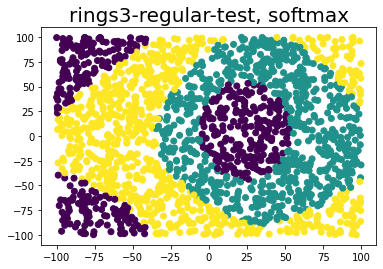

In [7]:
plt.scatter(test_df['x'], test_df['y'], c=result)
plt.title("rings3-regular-test, softmax", size=20)

Funkcja softmax poradziła sobie dobrze, patrząc na błędy w kolejnych epokach można wywnioskować, że przy większej liczbie iteracji, dopasowanie byłoby nadal zncznie lepsze.

## pierwszy zbiór - funkcja liniowa

In [8]:
mymlp = generate_random_mlp([2,64,64,64,64,3], output_function='linear')
mymlp.train(x_train_scaled, y_train, epochs = 1000, batch_size=2000, lr=0.01)
pred = mymlp.forward_prop(x_test_scaled)
result = np.argmax(pred, axis = 1)

Epoch: 0     Mean absolute error: 2.92877550203516
Epoch: 100   Mean absolute error: 0.6914321286415082
Epoch: 200   Mean absolute error: 0.6796169296528503
Epoch: 300   Mean absolute error: 0.6768458947933559
Epoch: 400   Mean absolute error: 0.6759860929580639
Epoch: 500   Mean absolute error: 0.6753022431311043
Epoch: 600   Mean absolute error: 0.6744870855314221
Epoch: 700   Mean absolute error: 0.6735011963940758
Epoch: 800   Mean absolute error: 0.6723850803277067
Epoch: 900   Mean absolute error: 0.6711722346503266
Epoch: 999   Mean absolute error: 0.6699027895170968


Text(0.5, 1.0, 'rings3-regular-test, linear')

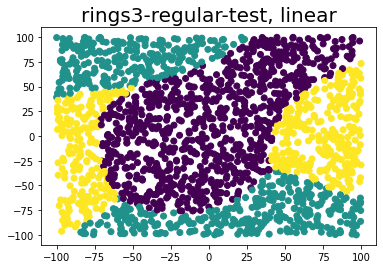

In [9]:
plt.scatter(test_df['x'], test_df['y'], c=result)
plt.title("rings3-regular-test, linear", size=20)

Funkcja liniowa poradziła sobie słabo, błąd maleje powoli, z wykresu nie można z dostateczną pewnością, stwierdzić czy dopasownie zbliża się do tego, co chcieliśmy otrzymać.

# Drugi zbiór: easy

In [10]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/classification/easy-training.csv')
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/classification/easy-test.csv')
train_df

,x,y,c
0,-72.829461,-40.239391,False
1,-65.464396,-60.501516,False
2,14.389589,74.223994,False
3,-92.335628,17.466916,False
4,-61.058421,-16.761820,False
...,...,...,...
495,96.279863,-95.125533,True
496,-41.625338,-48.713720,True
497,-64.545443,-91.317035,True
498,-27.066599,-89.894718,True


Text(0.5, 1.0, 'Train split')

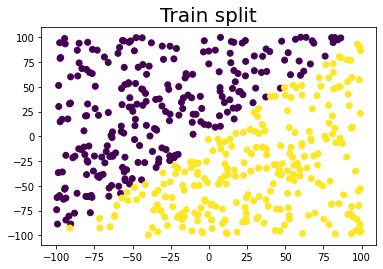

In [11]:
plt.scatter(train_df['x'], train_df['y'], c=train_df['c'])
plt.title('Train split', fontsize=20)

## skalowanie danych

In [12]:
x_train = np.asarray(train_df.iloc[:,0:2])
x_train_scaled = (x_train - np.mean(x_train, axis = 0))/np.std(x_train, axis = 0)

x_test = np.asarray(test_df.iloc[:,0:2])
x_test_scaled = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y_train = np.asarray(train_df.iloc[:,2]).reshape(-1, 1)
y_train = y_train.astype(int)

## drugi zbiór - funkcja softmax

In [13]:
mymlp = generate_random_mlp([2,64,64,64,64,2])
mymlp.train(x_train_scaled, y_train, epochs = 1000, batch_size=32, lr=0.01)
pred = mymlp.forward_prop(x_test_scaled)
result = np.argmax(pred, axis=1)

Epoch: 0     Cross entropy loss: 1.1010966591682396
Epoch: 100   Cross entropy loss: 0.21330483314083884
Epoch: 200   Cross entropy loss: 0.14509873267655232
Epoch: 300   Cross entropy loss: 0.11266018273399728
Epoch: 400   Cross entropy loss: 0.09311340074191848
Epoch: 500   Cross entropy loss: 0.079970039599769
Epoch: 600   Cross entropy loss: 0.07051621869545768
Epoch: 700   Cross entropy loss: 0.06339014595259691
Epoch: 800   Cross entropy loss: 0.05782932226051355
Epoch: 900   Cross entropy loss: 0.05337283252629127
Epoch: 999   Cross entropy loss: 0.04975849880313439


Text(0.5, 1.0, 'easy-test, softmax')

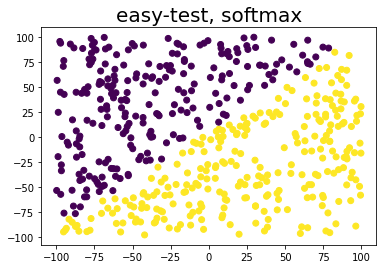

In [14]:
plt.scatter(test_df['x'], test_df['y'], c=result)
plt.title("easy-test, softmax", size=20)

W przypadku powyższego prostego zbioru, funkcja softmax dopasowała się  odpowiednio. 

## drugi zbiór - funckja liniowa

In [15]:
mymlp = generate_random_mlp([2,64,64,64,64,2], output_function='linear')
mymlp.train(x_train_scaled, y_train, epochs = 1000, batch_size=2000, lr=0.01)
pred = mymlp.forward_prop(x_test_scaled)
result = np.argmax(pred, axis = 1)

Epoch: 0     Mean absolute error: 2.974163781340158
Epoch: 100   Mean absolute error: 0.4180384309330158
Epoch: 200   Mean absolute error: 0.32450496667922435
Epoch: 300   Mean absolute error: 0.26438140741430866
Epoch: 400   Mean absolute error: 0.24043445319751955
Epoch: 500   Mean absolute error: 0.23048235609436718
Epoch: 600   Mean absolute error: 0.226114151209218
Epoch: 700   Mean absolute error: 0.22349727758546625
Epoch: 800   Mean absolute error: 0.22132723982463226
Epoch: 900   Mean absolute error: 0.21933928943173006
Epoch: 999   Mean absolute error: 0.21747360849395783


Text(0.5, 1.0, 'easy-test, linear')

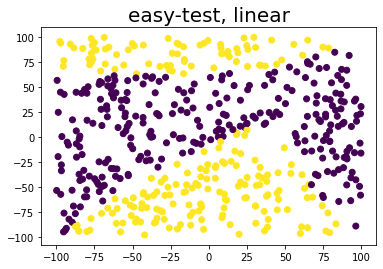

In [16]:
plt.scatter(test_df['x'], test_df['y'], c=result)
plt.title("easy-test, linear", size=20)

Funkcja liniowa nie poradziła sobie z tym zbiorem, stąd wnioskujemy, że nie nadaje się ona do problemów klasyfikacji.

# Trzeci zbiór: XOR3

In [17]:
train_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/classification/xor3-training.csv')
test_df = pd.read_csv('~/Documents/Sem6/MIO/datasets/classification/xor3-test.csv')
train_df

,x,y,c
0,-5.720316,18.198653,0
1,50.039419,-71.390360,0
2,93.072781,-76.340256,0
3,10.434100,-21.863272,0
4,30.198218,-24.730234,0
...,...,...,...
495,-88.821359,14.624647,1
496,57.830467,12.097832,1
497,-31.530983,90.372797,1
498,-17.008097,65.769246,1


Text(0.5, 1.0, 'Train split')

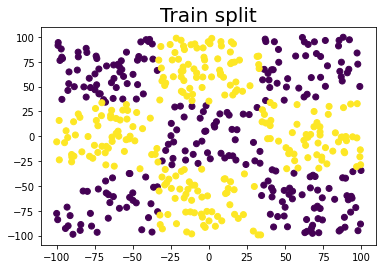

In [18]:
plt.scatter(train_df['x'], train_df['y'], c=train_df['c'])
plt.title('Train split', fontsize=20)

## skalowanie danych

In [19]:
x_train = np.asarray(train_df.iloc[:,0:2])
x_train_scaled = (x_train - np.mean(x_train, axis = 0))/np.std(x_train, axis = 0)

x_test = np.asarray(test_df.iloc[:,0:2])
x_test_scaled = (x_test - np.mean(x_test, axis = 0))/np.std(x_test, axis = 0)

y_train = np.asarray(train_df.iloc[:,2]).reshape(-1, 1)

## zbiór trzeci - funkcja softmax

In [20]:
mymlp = generate_random_mlp([2,64,64,64,64,2])
mymlp.train(x_train_scaled, y_train, epochs = 1000, batch_size=32, lr=0.01)
pred = mymlp.forward_prop(x_test_scaled)
result = np.argmax(pred, axis=1)

Epoch: 0     Cross entropy loss: 0.6496643336895562
Epoch: 100   Cross entropy loss: 0.6524371047305066
Epoch: 200   Cross entropy loss: 0.6453968562923444
Epoch: 300   Cross entropy loss: 0.6396480028228979
Epoch: 400   Cross entropy loss: 0.6345559156800891
Epoch: 500   Cross entropy loss: 0.629562476260332
Epoch: 600   Cross entropy loss: 0.6243384595838245
Epoch: 700   Cross entropy loss: 0.6186703944495462
Epoch: 800   Cross entropy loss: 0.6122735774331076
Epoch: 900   Cross entropy loss: 0.6046228234114674
Epoch: 999   Cross entropy loss: 0.5949854004848512


Text(0.5, 1.0, 'XOR3-test, softmax')

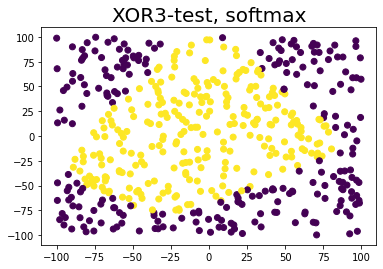

In [21]:
plt.scatter(test_df['x'], test_df['y'], c=result)
plt.title("XOR3-test, softmax", size=20)

Funkcja softmax poradziła sobie średnio dobrze, jednak patrząc na kolejne błędy, większa liczba epok wystarczy, aby sieć dopasowała się dobrze.

## zbiór trzeci - funkcja liniowa

In [22]:
mymlp = generate_random_mlp([2,64,64,64,64,2], output_function='linear')
mymlp.train(x_train_scaled, y_train, epochs = 1000, batch_size=2000, lr=0.01)
pred = mymlp.forward_prop(x_test_scaled)
result = np.argmax(pred, axis = 1)

Epoch: 0     Mean absolute error: 1.7748682867068675
Epoch: 100   Mean absolute error: 0.48543598571305957
Epoch: 200   Mean absolute error: 0.4866587504831643
Epoch: 300   Mean absolute error: 0.4869628786936641
Epoch: 400   Mean absolute error: 0.48683097400929487
Epoch: 500   Mean absolute error: 0.48649158173962875
Epoch: 600   Mean absolute error: 0.48605463892573336
Epoch: 700   Mean absolute error: 0.4855729385348623
Epoch: 800   Mean absolute error: 0.4850716049753552
Epoch: 900   Mean absolute error: 0.48456238936204477
Epoch: 999   Mean absolute error: 0.48405573440349403


Text(0.5, 1.0, 'rings3-regular-test, linear')

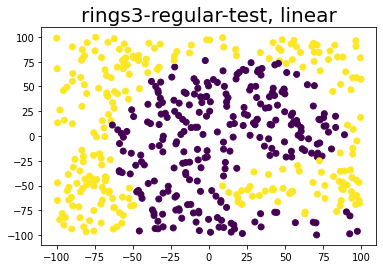

In [23]:
plt.scatter(test_df['x'], test_df['y'], c=result)
plt.title("rings3-regular-test, linear", size=20)

Jak możnabyło się spodziewać z analizy poprzednich zbiorów, funkcja liniowa znowu poradziła sobie dość słabo - zdecydowanie gorzej niż softmax.

# Wniosek

W przypadku klasyfikacji, funkcja liniowa radzi sobie słabo. Użycie innej funkcji aktywacji na wyjściu (takiej jak softmax) jest zatem kluczowe do tworzenia dobrych modeli i predykcji.